In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import itertools
import pickle
import matplotlib
import os

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle

In [2]:
os.chdir('C:\\Users\\iiroh\\Documents\\Projects\\Music Genre Classification\\features\\')
df = pd.read_csv('features_final.csv')
print(df.shape)
df.head()

(999, 140)


,centroid_max,centroid_min,centroid_mean,centroid_std,centroid_kurtosis,centroid_skew,zcr_max,zcr_min,zcr_mean,zcr_std,...,mfcc_18_kurtosis,mfcc_18_skew,mfcc_19_max,mfcc_19_min,mfcc_19_mean,mfcc_19_std,mfcc_19_kurtosis,mfcc_19_skew,tempo,label
0,4053.985673,925.934083,1727.645355,376.901924,6.096711,1.660034,0.299805,0.026367,0.083077,0.031171,...,0.954234,0.303920,34.931175,-25.915401,1.033782,7.581626,0.408693,0.241352,123.046875,0
1,5430.122461,372.728961,1450.533158,615.185827,4.766277,1.475144,0.397461,0.004883,0.056034,0.041543,...,1.002932,0.247480,31.484390,-20.805553,0.305456,7.547182,0.618586,0.401443,107.666016,0
2,4709.894987,356.735645,1493.679993,419.421447,11.343314,1.900807,0.450195,0.006836,0.076301,0.035163,...,0.347786,0.555627,19.085352,-29.447058,-2.110433,6.445112,0.502269,-0.048041,161.499023,0
3,3692.033659,261.951363,996.753301,428.061426,2.700672,1.111419,0.195312,0.005859,0.033303,0.022579,...,0.096114,-0.088479,24.258465,-23.636009,-1.658467,6.555074,0.942891,0.145058,172.265625,0
4,4484.855104,783.165978,1749.555484,599.338500,1.670321,1.118021,0.402344,0.032227,0.101478,0.047510,...,0.617877,0.049771,11.389920,-41.104294,-11.026450,8.213293,0.469296,-0.549097,135.999178,0


In [3]:
df.reset_index(inplace=True, drop=True)
cl_weight = dict(pd.Series(df['label']).value_counts(normalize=True))
y = df.pop('label').values
x = df.values

In [4]:
x

array([[ 4.05398567e+03,  9.25934083e+02,  1.72764535e+03, ...,
         4.08692816e-01,  2.41351947e-01,  1.23046875e+02],
       [ 5.43012246e+03,  3.72728961e+02,  1.45053316e+03, ...,
         6.18585631e-01,  4.01442885e-01,  1.07666016e+02],
       [ 4.70989499e+03,  3.56735645e+02,  1.49367999e+03, ...,
         5.02269329e-01, -4.80408929e-02,  1.61499023e+02],
       ...,
       [ 4.29529189e+03,  7.46216989e+02,  2.01626737e+03, ...,
         2.66741307e-01, -1.04794122e-01,  1.29199219e+02],
       [ 4.15120594e+03,  4.63391600e+02,  1.31480164e+03, ...,
         6.87959946e-02,  3.05120826e-01,  1.12347147e+02],
       [ 3.90001281e+03,  3.60754445e+02,  1.50493945e+03, ...,
         6.46422787e-01,  4.54525471e-01,  1.23046875e+02]])

In [5]:
scalar = MinMaxScaler()
features = scalar.fit_transform(x)

In [6]:
features.shape

(999, 139)

In [8]:
from sklearn.model_selection import train_test_split

features_train, features_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state = 42, stratify = y)

In [9]:
features_train

array([[0.31560433, 0.2349768 , 0.19222978, ..., 0.24403552, 0.85695643,
        0.29217391],
       [0.44258908, 0.51565159, 0.50145207, ..., 0.17187068, 0.67405955,
        0.5173913 ],
       [0.51603943, 0.36754334, 0.50594367, ..., 0.10934792, 0.47533935,
        0.3705104 ],
       ...,
       [0.53337207, 0.63686256, 0.72901628, ..., 0.16442955, 0.34213044,
        0.41501976],
       [0.51721295, 0.2491435 , 0.46333232, ..., 0.14055856, 0.47847674,
        0.46376812],
       [0.53198716, 0.24133415, 0.31451233, ..., 0.16839493, 0.45126706,
        0.25752508]])

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm = True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), 10)
    print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=label_dict.keys())

In [11]:
label_dict = {'blues':0,
              'classical':1,
              'country':2,
              'disco':3,
              'hiphop':4,
              'jazz':5,
              'metal':6,
              'pop':7,
              'reggae':8,
              'rock':9,
             }

C:\Users\iiroh\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:40:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "sub_sample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Test Set Accuracy =  0.69
Test Set F-score =  0.69
ROC AUC = 0.943
Confusion matrix, without normalization
[[13  0  1  1  1  1  0  0  2  1]
 [ 0 19  0  0  0  1  0  0  0  0]
 [ 3  0 10  1  0  0  0  1  1  4]
 [ 0  1  1 11  4  0  0  1  1  1]
 [ 1  0  0  2 14  0  0  1  2  0]
 [ 0  1  1  0  0 18  0  0  

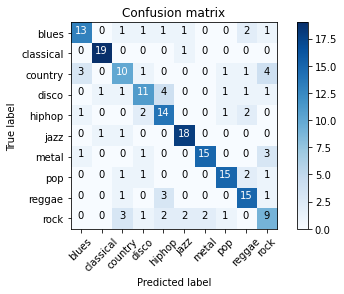

In [12]:
%%time

xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = 10)
xgb_classifier.fit(features_train, y_train)


pred_probs = xgb_classifier.predict_proba(features_test)


display_results(y_test, pred_probs)

Test Set Accuracy =  0.77
Test Set F-score =  0.76
ROC AUC = 0.964
Confusion matrix, without normalization
[[17  0  0  2  0  0  0  0  0  1]
 [ 0 19  0  0  0  1  0  0  0  0]
 [ 4  0 12  1  0  0  0  0  1  2]
 [ 0  1  0 10  3  0  0  4  0  2]
 [ 0  0  0  2 15  0  0  1  0  2]
 [ 0  0  0  0  0 20  0  0  0  0]
 [ 0  0  0  1  1  0 18  0  0  0]
 [ 0  0  1  1  0  0  0 17  1  0]
 [ 0  0  1  1  2  0  0  1 15  0]
 [ 0  0  2  0  1  1  2  2  2 10]]
Wall time: 1.07 s


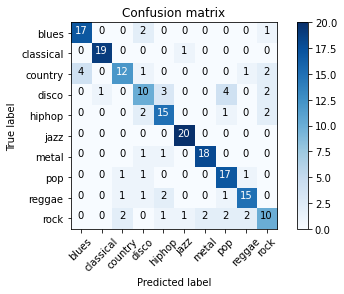

In [13]:
%%time

svm_classifier = SVC(C=10000.0, probability = True, class_weight=cl_weight, kernel='rbf')
svm_classifier.fit(features_train, y_train)

pred_probs_svm = svm_classifier.predict_proba(features_test)

display_results(y_test, pred_probs_svm)

Test Set Accuracy =  0.69
Test Set F-score =  0.69
ROC AUC = 0.954
Confusion matrix, without normalization
[[ 9  0  3  2  0  1  0  0  4  1]
 [ 0 20  0  0  0  0  0  0  0  0]
 [ 4  0 13  0  0  0  0  0  1  2]
 [ 0  0  1 12  4  1  0  2  0  0]
 [ 0  0  0  4 13  0  0  1  2  0]
 [ 0  2  1  0  0 16  0  0  0  1]
 [ 1  0  0  1  0  0 16  0  0  2]
 [ 0  0  2  1  1  0  0 16  0  0]
 [ 0  0  1  1  4  0  0  0 14  0]
 [ 1  0  1  0  0  2  4  1  2  9]]
Wall time: 4.45 s


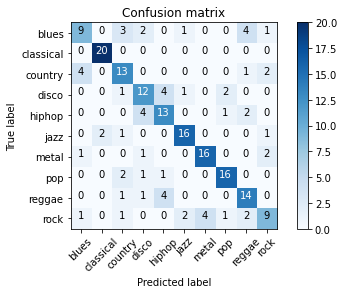

In [15]:
%%time

rf_classifier = RandomForestClassifier(n_estimators=500, min_samples_split=5)
rf_classifier.fit(features_train, y_train)

# Predict
pred_probs_rf = rf_classifier.predict_proba(features_test)

# Results
display_results(y_test, pred_probs_rf)

In [18]:
pickle.dump(xgb_classifier, open('finalized_model_xbg.pkl','wb'))
pickle.dump(svm_classifier, open('finalized_model_svm.pkl','wb'))
pickle.dump(rf_classifier, open('finalized_model_rf.pkl','wb'))

C:\Users\iiroh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Set Accuracy =  0.74
Test Set F-score =  0.74
ROC AUC = 0.960
Confusion matrix, without normalization
[[14  0  1  1  1  0  1  0  1  1]
 [ 0 18  0  0  0  2  0  0  0  0]
 [ 4  0 12  1  0  0  0  0  1  2]
 [ 0  0  1 11  3  0  0  3  0  2]
 [ 0  0  0  2 16  0  0  2  0  0]
 [ 0  0  0  0  0 20  0  0  0  0]
 [ 1  0  0  0  0  0 18  0  0  1]
 [ 0  0  0  0  0  0  0 18  2  0]
 [ 0  0  2  0  4  0  0  0 14  0]
 [ 0  0  2  0  1  2  3  2  2  8]]


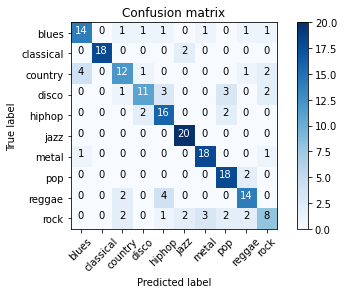

In [20]:
lr_classifier = LogisticRegression(penalty='l2')
lr_classifier.fit(features_train, y_train)

# Predict
pred_probs_rf = lr_classifier.predict_proba(features_test)

# Results
display_results(y_test, pred_probs_rf)

In [21]:
pickle.dump(lr_classifier, open('finalized_model_lr.pkl','wb'))

In [22]:
df1 = df.iloc[:, 18:]

In [23]:
df1

,mfcc_0_max,mfcc_0_min,mfcc_0_mean,mfcc_0_std,mfcc_0_kurtosis,mfcc_0_skew,mfcc_1_max,mfcc_1_min,mfcc_1_mean,mfcc_1_std,...,mfcc_18_std,mfcc_18_kurtosis,mfcc_18_skew,mfcc_19_max,mfcc_19_min,mfcc_19_mean,mfcc_19_std,mfcc_19_kurtosis,mfcc_19_skew,tempo
0,-50.648464,-330.431152,-186.460526,52.133774,-0.393316,0.064054,171.176727,43.733589,123.127106,18.383476,...,8.289201,0.954234,0.303920,34.931175,-25.915401,1.033782,7.581626,0.408693,0.241352,123.046875
1,-85.468452,-519.970947,-280.332001,89.136299,-0.465977,-0.446249,203.420197,18.886454,126.103172,25.138149,...,8.132369,1.002932,0.247480,31.484390,-20.805553,0.305456,7.547182,0.618586,0.401443,107.666016
2,-30.900656,-430.369202,-165.280289,61.597019,0.663060,-0.628754,207.347534,-16.732559,143.579773,24.646816,...,7.640779,0.347786,0.555627,19.085352,-29.447058,-2.110433,6.445112,0.502269,-0.048041,161.499023
3,-80.188515,-444.089996,-270.670959,75.114777,-0.417630,0.052589,246.168915,52.522026,155.397095,22.947124,...,7.169939,0.096114,-0.088479,24.258465,-23.636009,-1.658467,6.555074,0.942891,0.145058,172.265625
4,-70.562256,-444.669006,-235.646545,74.043617,-0.565686,-0.232620,195.452362,-17.397953,130.374512,31.102262,...,8.474621,0.617877,0.049771,11.389920,-41.104294,-11.026450,8.213293,0.469296,-0.549097,135.999178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,-91.570930,-374.751099,-221.451767,49.664501,-0.135687,-0.251100,168.562195,30.192616,115.439384,23.029125,...,8.146311,0.652789,-0.398851,27.768505,-24.332977,-1.048877,7.841194,-0.070797,-0.022732,103.359375
995,-109.300713,-439.878937,-210.498566,56.612175,3.159467,-1.552240,175.493927,51.520985,119.799995,19.305666,...,7.038724,-0.033834,-0.158577,14.587259,-22.858486,-2.435451,6.170759,-0.231248,-0.008819,117.453835
996,-97.789948,-363.247131,-194.109924,41.164501,1.487040,-0.887743,181.683060,31.574036,117.510994,22.421862,...,7.164512,0.235566,0.250594,19.207455,-24.521164,-1.937717,6.127213,0.266741,-0.104794,129.199219
997,-136.581345,-615.758911,-294.718506,103.643608,0.988649,-1.386724,189.289825,18.544956,128.023911,22.917339,...,7.700096,0.042892,0.248580,21.099937,-24.144234,-3.360137,7.236962,0.068796,0.305121,112.347147
